### Preparing the Input for 12-lead

In [2]:
import os
from sklearn.preprocessing import StandardScaler
#import wfdb as wf
import numpy as np
import matplotlib.pyplot as plt
from biosppy.signals import ecg
import glob
from scipy import signal
import pandas as pd
from tensorflow.python.keras.layers import Dense, Convolution1D, Convolution2D,MaxPool1D, Flatten, Dropout
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.normalization import BatchNormalization
import tensorflow.python.keras
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.utils.np_utils import to_categorical
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from sklearn import preprocessing
import pandas as pd
import numpy as np
import os,glob
import math
import fnmatch
import re
import gc
import shutil
from joblib import Parallel, delayed
#import matplotlib.pyplot as plt
import scipy.signal as scipysi
import xgboost as xgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, GRU
import shutil
#import matplotlib as plt
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape,CuDNNLSTM,GlobalMaxPooling1D, MaxPool2D,Flatten
from tensorflow.python.keras.layers import Conv1D, Conv2D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, GlobalAveragePooling2D,Concatenate
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import initializers
from tensorflow.keras import regularizers, constraints
import tensorflow.keras.backend as K


from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from scipy import signal
from scipy.fft import fftshift

/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

### Loading data and playing with it

In [3]:
#constants

TARGET_SAMPLING_RATE=250
DATA_SAMPLING_RATE=500
INPUT_BEAT_SIZE=300

#paths
root_path='/Users/aring/Desktop/ECG-identification/Arnold-data'

DataFilePath = root_path+'/NoiseReductionData/'
LeadInfoFilePath = root_path+'/DiagnosisFiles/MissingLeadInfo/'
RepDiagnosisFileName = root_path+'/DiagnosisFiles/RepatTranslationDiagAfterRemDupAndBDQ_CHS20200531_ToArinG.xlsx'
FullDiagnosisFileName = root_path+'/DiagnosisFiles/TranslationDiagAfterRemDupAndBDQ_CHS20200531_ToArinG.xlsx'

In [4]:
RepDiagnosisDF = pd.read_excel(RepDiagnosisFileName)
RepDiagnosisDF.head(n=100)

,FileName,PatientID,DOB,Age,Gen,TimeAcquisition,Translation
0,MUSE_20180113_180130_23000,219,1011931.0,85,Male,29/12/2016 10:52:16,['Sinus_Tachycardia']
1,MUSE_20180113_180131_30000,219,1011931.0,86,Male,29/05/2017 10:10:54,['Sinus_Tachycardia']
2,MUSE_20180113_180139_35000,219,1011931.0,86,Male,03/06/2017 07:34:27,['Sinus_Tachycardia']
3,MUSE_20180113_180143_59000,219,1011931.0,86,Male,04/11/2017 11:46:50,['Sinus_Tachycardia']
4,MUSE_20180113_131105_22000,542,1011931.0,86,Female,26/01/2017 12:50:33,[ 'Ventricular_Escape_Beat']
...,...,...,...,...,...,...,...
95,MUSE_20180116_131237_15000,105952,1011936.0,80,Male,20/05/2016 09:08:08,"['Atrial_Fibrillation', 'Pacemaker_ECG', 'Pace..."
96,MUSE_20180116_131235_03000,105952,1011936.0,81,Male,17/01/2017 11:11:45,['Atrial_Fibrillation']
97,MUSE_20180116_131239_26000,105952,1011936.0,80,Male,16/03/2016 19:09:09,['Atrial_Fibrillation']
98,MUSE_20180116_131240_34000,105952,1011936.0,81,Male,23/07/2017 08:52:27,['Atrial_Fibrillation']


In [5]:
RepDiagnosisDF.shape

(8980, 7)

In [6]:
FullDiagnosisDF = pd.read_excel(FullDiagnosisFileName)
FullDiagnosisDF

,FileName,PatientID,DOB,Age,Gen,TimeAcquisition,Translation
0,MUSE_20180115_124154_98000,880947374,1012016.0,20,Female,25/09/2017 15:32:26,[ 'Sinus_Tachycardia']
1,MUSE_20180112_071158_01000,880957431,1012016.0,22,Female,16/11/2017 15:55:09,[ 'Sinus_Tachycardia']
2,MUSE_20180114_123835_64000,880878772,1011949.0,67,Female,26/10/2016 10:55:48,"[ 'Clockwise_Rotation', 'Complete_LBBB', 'Sinu..."
3,MUSE_20180210_124733_04000,2968425,1011949.0,68,Male,04/11/2017 19:30:02,"[ 'Clockwise_Rotation', 'Myocardial_Infarction..."
4,MUSE_20180118_173322_76000,10956457,1011952.0,65,Female,10/05/2017 10:35:22,"[ 'Clockwise_Rotation', 'Sinus_Tachycardia']"
...,...,...,...,...,...,...,...
45303,MUSE_20180116_121305_58000,880938543,1011981.0,36,Male,15/08/2017 16:32:00,['VT']
45304,MUSE_20180120_123539_01000,880968276,1011988.0,30,Female,16/01/2018 18:06:02,['VT']
45305,MUSE_20180120_122254_36000,10183314,1012010.0,6,Female,23/11/2016 20:19:05,['Wandering_Pacemakerwithin_Sinoatrial_Node']
45306,MUSE_20180116_124311_28000,11106793,1011938.0,78,Female,16/01/2016 11:41:35,['Wandering_Pacemakerwithin_Sinoatrial_Node']


In [6]:
FullDiagnosisDF.shape

(45308, 7)

In [7]:
leadinfoDF = pd.read_excel(LeadInfoFilePath + 'MUSE_20180111_170356_27000' + '.xlsx')
leadinfoDF.head()

,Var1,Var2
0,True,False
1,True,False
2,True,False
3,True,False
4,True,False


In [8]:
leadinfoDF.shape

(12, 2)

In [9]:
sample_record = pd.read_csv(DataFilePath + 'NoiseReductionData1/'+'MUSE_20180112_070939_20000' + '.csv', header=None)
sample_record.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-44.944,-16.279,8.5933,25.355,-26.101,-6.0976,-51.235,-57.090,-45.905,-54.620,-21.231,14.0490
1,-50.910,-22.374,8.6467,31.734,-28.214,-8.6359,-51.259,-60.730,-49.903,-57.047,-24.873,7.9470
2,-57.153,-29.420,8.0254,38.785,-30.269,-12.1520,-51.659,-64.809,-53.887,-59.625,-29.008,1.6642
3,-63.350,-37.508,6.3144,46.402,-31.999,-16.9680,-52.452,-69.387,-57.537,-62.235,-33.709,-4.5832
4,-68.634,-45.746,3.5399,53.644,-33.037,-22.5800,-53.271,-74.064,-60.240,-64.508,-38.522,-10.1500


In [10]:
sample_record.shape

(5000, 12)

In [11]:
channel = sample_record[0].values
ecg_info_extracted = ecg.ecg(signal=channel, sampling_rate=DATA_SAMPLING_RATE, show=False)
num_of_beats=ecg_info_extracted['templates'].shape[0]
beat_size=ecg_info_extracted['templates'].shape[1]
print(num_of_beats)
print(beat_size)

19
300


In [12]:
heart_beats_12lead = np.array(ecg_info_extracted['templates'], dtype=np.float)
heart_beats_12lead.shape

(19, 300)

In [13]:
channel = sample_record[1].values
ecg_info_extracted = ecg.ecg(signal=channel, sampling_rate=DATA_SAMPLING_RATE, show=False)
heart_beats_12lead=np.append(heart_beats_12lead,ecg_info_extracted['templates'],1)
heart_beats_12lead.shape


(19, 600)

In [14]:
if any(~leadinfoDF.iloc[:, 0]):
    print('missing some leaseds!')
else:
     print('has all leads!')

has all leads!


In [15]:
#this creates a matrix where  each row is a beat, 12 leads stored one after another in that row (each lead is 300 smaples)
for i in [1,0,2,3,4,5,6,7,8,9,10,11]:
    channel = sample_record[i].values
    try:
        ecg_info_extracted = ecg.ecg(signal=channel, sampling_rate=DATA_SAMPLING_RATE, show=False)
        if i==1:
            heart_beats_12lead = np.array(ecg_info_extracted['templates'], dtype=np.float)
            lead1_beats=ecg_info_extracted['templates']
        else:
            heart_beats_12lead = np.append(heart_beats_12lead,ecg_info_extracted['templates'],1)
    except Exception as e:
        if i==1:
            break
        print('error in processing the leads:'+ str(i))
        heart_beats_12lead = np.append(heart_beats_12lead,np.zeros_like(lead1_beats),1)
        continue


heart_beats_12lead.shape


(19, 3600)

In [16]:
ecg_info_extracted['templates'].shape

(19, 300)

In [17]:
heart_beats_12lead[:,2*300:3*300]

array([[-18.13456949, -17.62687377, -17.08459724, ..., -20.57877766,
        -23.10124215, -25.19957523],
       [-17.13388225, -16.28698359, -15.31613171, ..., -21.90872581,
        -23.85870663, -24.6684356 ],
       [-13.35416922, -13.0744338 , -12.77143781, ..., -17.46681087,
        -19.04744205, -21.00455269],
       ...,
       [-14.77531711, -14.28855901, -13.87134876, ..., -18.76016624,
        -18.4452355 , -19.0769272 ],
       [-13.35531235, -12.73198025, -12.17661534, ...,  -7.53141091,
         -8.95909886, -10.90518262],
       [-14.32165088, -13.3106402 , -12.43055031, ..., -11.62177154,
        -12.16643547, -13.23792191]])

In [18]:
beat1_12lead = np.reshape(heart_beats_12lead[0], (12, 300))
beat1_12lead.shape

(12, 300)

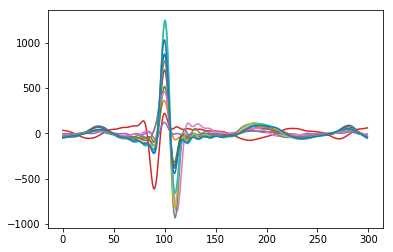

In [19]:
#draw all 12 leads for the first beat
for i in range(0,11):
    plt.plot( beat1_12lead[i,:]) 

plt.show()

In [20]:
#add the lalber to each row for each beat
beat1_12lead
num_patientID=123
label_column = np.repeat(num_patientID, beat1_12lead.shape[0])
label_column=np.reshape(label_column, (label_column.shape[0], 1))
beat1_12lead_with_label=np.append(beat1_12lead,label_column,1)
print(beat1_12lead_with_label.shape)
# print(beat1_12lead_with_label[0,])

(12, 301)


### Preprocssing 12-lead data and Storing the input to NN

In [21]:


def generate_12lead_input_for_NN(num_patientID, diagnosis, signalFile):
    NoiseReductionData_dirs=['NoiseReductionData1','NoiseReductionData2','NoiseReductionData3','NoiseReductionData4','NoiseReductionData5','NoiseReductionData6']
    path_does_not_Exist=True
    for dir_name in NoiseReductionData_dirs:
        path = DataFilePath + dir_name+'/'+ signalFile + '.csv'
        if os.path.exists(path):
            path_does_not_Exist=False
            break;
    if path_does_not_Exist:
        print('File does not exist:', signalFile)
        return np.repeat(None, 1)
    
    all_beats_12lead_with_label_diagnosis = np.empty((0,12,INPUT_BEAT_SIZE+2), dtype=np.float)
    record = pd.read_csv(path, header=None)
    leadinfoDF = pd.read_excel(LeadInfoFilePath + signalFile + '.xlsx')
    
    for i in [1,0,2,3,4,5,6,7,8,9,10,11]:
        channel = record[i].values
        try:
            ecg_info_extracted = ecg.ecg(signal=channel, sampling_rate=DATA_SAMPLING_RATE, show=False)
            if i==1:
                heart_beats_12lead = np.array(ecg_info_extracted['templates'], dtype=np.float)
                lead1_beats=ecg_info_extracted['templates']
                num_of_beats=lead1_beats.shape[0]
            else:
                heart_beats_12lead = np.append(heart_beats_12lead,ecg_info_extracted['templates'],1)
        except Exception as e:
            if i==1:
                return np.repeat(None, 1)
            else:
                heart_beats_12lead = np.append(heart_beats_12lead,np.zeros_like(lead1_beats),1)
                
    for i in range(0,num_of_beats):
        one_beat_12lead = np.reshape(heart_beats_12lead[i], (12, 300))
        label_column = np.repeat(num_patientID, one_beat_12lead.shape[0])
        label_column=np.reshape(label_column, (label_column.shape[0], 1))
        diagnosis_column=np.repeat(diagnosis, one_beat_12lead.shape[0])
        diagnosis_column=np.reshape(diagnosis_column, (diagnosis_column.shape[0], 1))
        one_beat_12lead_with_label = np.append(one_beat_12lead,label_column,1)
        one_beat_12lead_with_label_diagnosis = np.append(one_beat_12lead_with_label,diagnosis_column,1)
        one_beat_12lead_with_label_diagnosis = np.reshape(one_beat_12lead_with_label_diagnosis,(1,12,302))
        all_beats_12lead_with_label_diagnosis=np.vstack((all_beats_12lead_with_label_diagnosis,one_beat_12lead_with_label_diagnosis))
    

    return all_beats_12lead_with_label_diagnosis

   

In [22]:
x=generate_12lead_input_for_NN(123,['Sinus_Tachycardia'],'MUSE_20180111_170356_27000')

In [23]:
x[0]

array([['-40.719956926829624', '-40.844754001609466',
        '-40.63335164906105', ..., '54.31228077099648', '123.0',
        'Sinus_Tachycardia'],
       ['-14.299994121880898', '-12.951280481990485',
        '-11.416985294399705', ..., '14.764532947005735', '123.0',
        'Sinus_Tachycardia'],
       ['0.0', '0.0', '0.0', ..., '0.0', '123.0', 'Sinus_Tachycardia'],
       ...,
       ['-15.00218762655504', '-13.176144880710474',
        '-11.256069088311921', ..., '34.55045611154739', '123.0',
        'Sinus_Tachycardia'],
       ['-3.9269471638104085', '-4.477020922562214',
        '-4.846829608520115', ..., '22.714660699953154', '123.0',
        'Sinus_Tachycardia'],
       ['-16.29128183523312', '-14.2946982583345', '-12.115651880793529',
        ..., '29.797783843492336', '123.0', 'Sinus_Tachycardia']],
      dtype='<U32')

In [24]:
NonRepDiagnosisDF = FullDiagnosisDF.loc[~FullDiagnosisDF['FileName'].isin(RepDiagnosisDF['FileName'])]
NonRepDiagnosisDF = NonRepDiagnosisDF.reset_index(drop=True)
NonRepDiagnosisDF['PatientID'] = NonRepDiagnosisDF['FileName']

AllDiagnosisDF = pd.concat([RepDiagnosisDF, NonRepDiagnosisDF])
AllDiagnosisDF = AllDiagnosisDF.reset_index(drop=True)
le = preprocessing.LabelEncoder()
AllDiagnosisDF['PatientID'] = AllDiagnosisDF['PatientID'].astype('str')
AllDiagnosisDF['PatientID'] = le.fit_transform(AllDiagnosisDF['PatientID'])


In [ ]:

num_cores =6
   

results = Parallel(n_jobs=num_cores)(delayed(generate_12lead_input_for_NN)
            (AllDiagnosisDF['PatientID'][indexFile],AllDiagnosisDF['Translation'][indexFile],signalFile) for indexFile, signalFile in enumerate(AllDiagnosisDF['FileName']))


/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:

# Save to CSV file.
outfn = root_path+'/FeatureArray_stacked_pcs.csv'
print('Generating ', outfn)
with open(outfn, "wb") as fin:
    np.savetxt(fin, FeatureArray3, delimiter=",", fmt='%f')


In [ ]:
len(results)

In [ ]:
def split_train_test(patient_rows):
    random_rows=np.random.choice(patient_rows.shape[0], size=2, replace=False)
    test=patient_rows[random_rows,:,:]
    train=np.delete(patient_rows,random_rows,0)
    return train,test

train,test = map(list,zip(*[split_train_test(i) for i in results if  i.any()]))

In [ ]:
print(len(train))
print(len(test))
num_of_people_in_data=len(train)


In [ ]:
train_stacked = np.row_stack(train)
test_stacked = np.row_stack(test)

print('train beats: '+str(train_stacked.shape))
print('test beats: '+str(test_stacked.shape))
print('total number of beats: '+str(train_stacked.shape[0]+test_stacked.shape[0]))

In [ ]:
train_X=train_stacked[:,:,:-2]
train_y=train_stacked[:,:,-2]
train_diagnosis=train_stacked[:,:,-1]

test_X=test_stacked[:,:,:-2]
test_y=test_stacked[:,:,-2]
test_diagnosis=train_stacked[:,:,-1]


print('train_X: '+str(train_X.shape))
print('train_y: '+str(train_y.shape))
print('train_diagnosis: '+str(train_diagnosis.shape))


print('test_X: '+str(test_X.shape))
print('test_X: '+str(test_y.shape))
print('test_diagnosis: '+str(test_diagnosis.shape))



In [ ]:

# reshaping to 2D array so that npsavetxt can save it
outfn = root_path+'/nn-input/train_X.csv'
with open(outfn, "wb") as fin:
    np.savetxt(fin, train_X.reshape((train_X.shape[0],12*300)), delimiter=",", fmt='%f')


# Save to CSV file.
outfn = root_path+'/nn-input/train_y.csv'
with open(outfn, "wb") as fin:
    np.savetxt(fin, train_y, delimiter=",", fmt='%f')


# Save to CSV file.
outfn = root_path+'/nn-input/test_X.csv'
with open(outfn, "wb") as fin:
    np.savetxt(fin, test_X.reshape((test_X.shape[0],12*300)), delimiter=",", fmt='%f')

    

# Save to CSV file.
outfn = root_path+'/nn-input/test_y.csv'
with open(outfn, "wb") as fin:
    np.savetxt(fin, test_y, delimiter=",", fmt='%f')
    


# Save to CSV file.
outfn = root_path+'/nn-input/test_diagnosis.csv'
with open(outfn, "wb") as fin:
    np.savetxt(fin, test_diagnosis, delimiter=",", fmt='%f')
    
    


# Save to CSV file.
outfn = root_path+'/nn-input/train_diagnosis.csv'
with open(outfn, "wb") as fin:
    np.savetxt(fin, train_diagnosis, delimiter=",", fmt='%f')
